### Analysis

In [6]:
!pip install mat73 >> None
!pip install filters >> None
!pip install measure >> None
!pip install segmentation >> None

In [10]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import OrderedDict

from skimage import io
from skimage.measure import regionprops,find_contours
from skimage.segmentation import join_segmentations
from sklearn.metrics.pairwise import euclidean_distances

drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
def video_prep (smoothed_video, threshold=20):
    data_dict_smoothed = mat73.loadmat(smoothed_video)
    struct = data_dict_smoothed['smoothed_video']

    print('struct min', struct.min())
    print('struct max', struct.max())
    fig1 = intensity_distribution (struct)[0]
    fig2 = intensity_per_frame(intensity_mean(struct, threshold))

    first_frame = struct[:, :, 0]
    plt.imshow(first_frame)
    plt.title('Первый кадр')
    plt.show()

    del data_dict_smoothed, struct

    return fig1, fig2

def intensity_mean (struct, threshold):
    bright_mean_per_frame = []
    for frame in range (1200):
        I=struct[0:1024, 0:1024, frame]>=threshold
        bright_mean_per_frame.append(np.mean(struct[0:1024, 0:1024, frame][I]))
    return bright_mean_per_frame

def intensity_distribution (struct):
    flat_struct_0 = struct[:, :, 0].flatten()
    flat_struct_800 = struct[:, :, 880].flatten()
    qauntile_0_95 = np.quantile(flat_struct_0, 0.95)
    print ('quantile 0.95', qauntile_0_95)

    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,10])
    ax1.hist(flat_struct_0, bins=100, log=True)
    ax2.hist(flat_struct_800, bins=100, log=True)

    ax1.set_xlabel('Intensity, 0 frame')
    ax1.set_ylabel('number of pixels')
    ax2.set_xlabel('Intensity, 800 frame')
    ax2.set_ylabel('number of pixels')
    plt.savefig("fig1.png")
    fig1 = plt.show()
    return fig1, qauntile_0_95

def intensity_per_frame (bright_mean_per_frame):
    plt.plot(bright_mean_per_frame)
    plt.xlabel('frames')
    plt.ylabel('Intensity')
    plt.savefig("fig2.png")
    fig2 = plt.show()
    return fig2

struct min -7.10269
struct max 143.80998
quantile 0.95 18.89964008331299


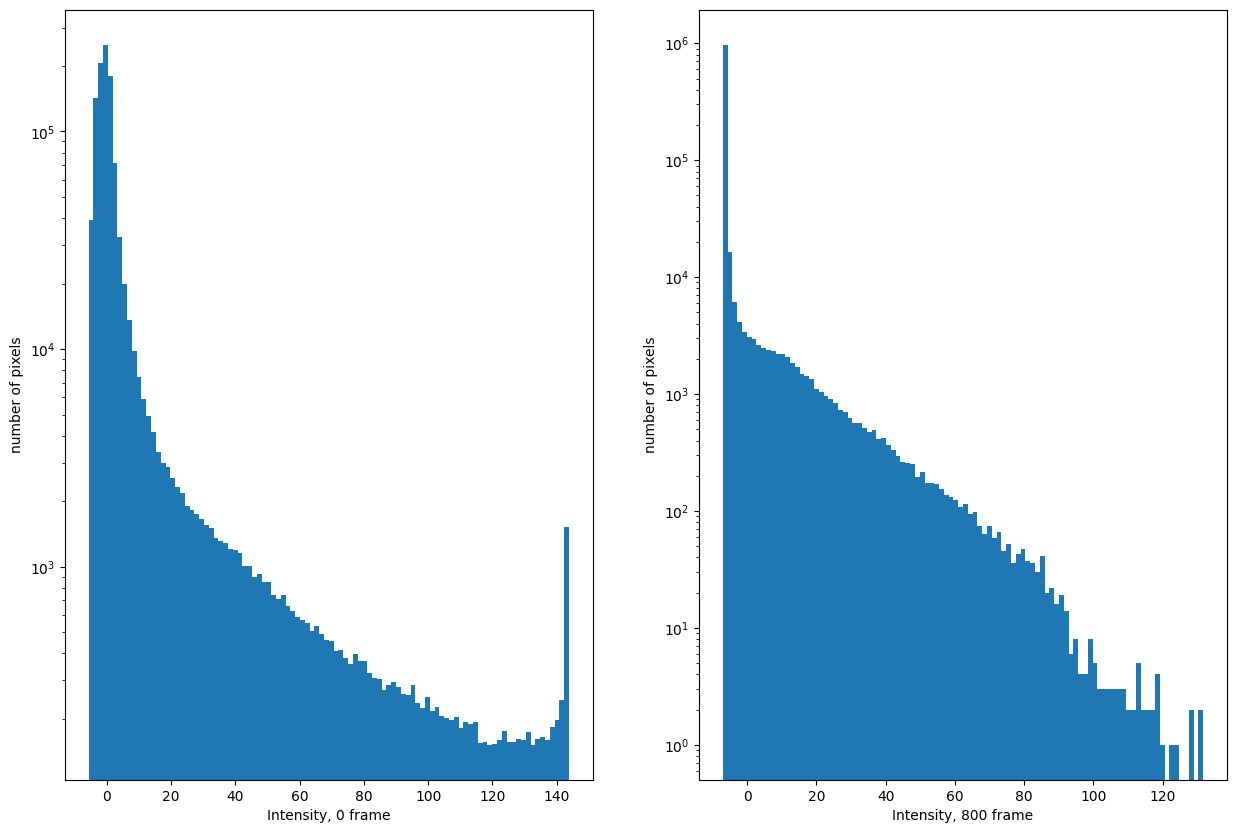

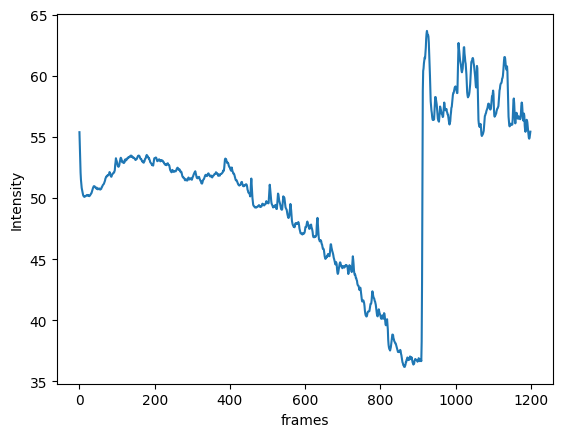

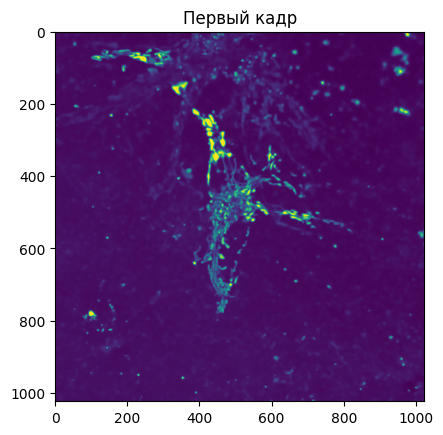

In [12]:
div10_1 = video_prep('/content/drive/MyDrive/ColabNotebooks/smoothed_video.mat')

### SAM

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai
!pip install patchify

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify
import random
from scipy import ndimage

Выгружается tif файлы с изображениями клеток и масками, покрывающие зоны, где находятся митохондрии.

In [16]:
large_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/training.tif")
large_masks = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/training_groundtruth.tif")

In [17]:
large_masks.shape

(165, 768, 1024)

In [18]:
patch_size = 256
step = 256

Создается пустой список all_img_patches, который будет использоваться для сохранения всех сгенерированных патчей изображений.
С помощью функции patchify изображение large_image разбивается на патчи размером (patch_size, patch_size) с заданным шагом step. То же проделывается и для масок.

In [19]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

In [20]:
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [21]:
masks.shape

(1980, 256, 256)

Далее выбираем только те маски и соответствующие им картинки, где есть митохондрии.

In [22]:
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)
print("Mask shape:", filtered_masks.shape)

Image shape: (1642, 256, 256)
Mask shape: (1642, 256, 256)


Создаем объект Dataset из словаря, содержащий изображения и соответствующие им маски.

In [23]:
from datasets import Dataset
from PIL import Image

dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

dataset = Dataset.from_dict(dataset_dict)

In [24]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1642
})

Выведем любую рандомно взятую пару изображения и маски.

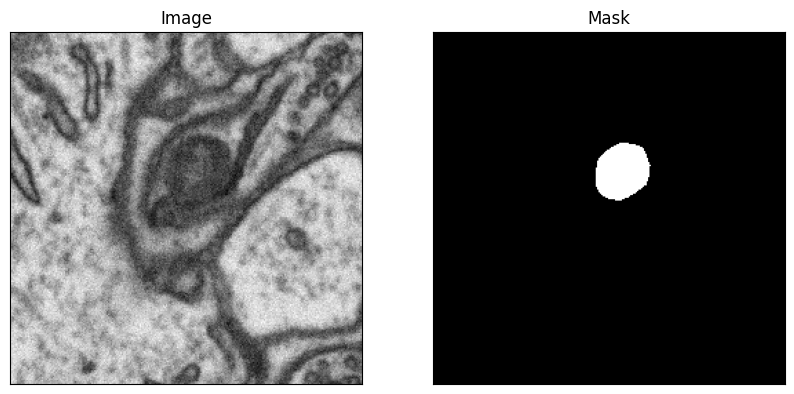

In [25]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

Функция get_bounding_box принимает маску в качестве входного аргумента и вычисляет охватывающий прямоугольник (Bounding Box) для области с положительными значениями маски, добавляя случайное отклонение к его координатам.

In [26]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

Определим пользовательский класс SAMDataset, который является подклассом torch.utils.data.Dataset. Класс Dataset предоставляет интерфейс для доступа к данным в PyTorch и используется для обработки и подготовки данных перед их передачей в модель обучения.

Создается словарь inputs, в котором обработанные данные сохраняются в виде тензоров PyTorch. К маске истинных значений добавляется ключ "ground_truth_mask", и весь словарь inputs возвращается как результат метода __getitem__.

In [27]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    prompt = get_bounding_box(ground_truth_mask)
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

Далее импортируется класс SamProcessor из библиотеки transformers. transformers - это популярная библиотека, разработанная компанией Hugging Face, которая предоставляет высокоуровневые интерфейсы для работы с моделями глубокого обучения для обработки естественного языка (NLP) и компьютерного зрения (CV).

Строка processor = SamProcessor.from_pretrained("facebook/sam-vit-base") создает экземпляр класса SamProcessor, используя предобученные веса модели "facebook/sam-vit-base".

In [28]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [29]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [30]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


Здесь импортируется класс DataLoader из модуля torch.utils.data библиотеки PyTorch. DataLoader предоставляет удобный способ загрузки данных в модель обучения пакетами (batch) во время обучения.

Строка train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False) создает объект train_dataloader, который будет использоваться для загрузки данных из train_dataset в модель обучения.





In [31]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [32]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [33]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

Здесь импортируется класс SamModel из библиотеки transformers и создает экземпляр модели model на основе предобученных весов модели "facebook/sam-vit-base".

SamModel является моделью компьютерного зрения, основанной на архитектуре SAM (Spatially Adaptive Masking), разработанной Facebook AI Research. Модель "facebook/sam-vit-base" является предобученной версией модели SAM.

Rод замораживает параметры визионного энкодера (vision_encoder) и энкодера подсказки (prompt_encoder), чтобы они оставались неизменными во время обучения модели. Это может быть полезно, если мы хотим использовать предобученные веса для извлечения признаков или для выполнения инференса, не обновляя эти веса в процессе обучения.

In [34]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

Здесь импортируется класс Adam из модуля torch.optim и класс DiceCELoss из модуля monai.losses. Затем он создает объект optimizer и объект seg_loss.

Adam - это оптимизатор, используемый для обновления весов модели во время обучения с использованием алгоритма оптимизации Adam. В данном случае, Adam используется для оптимизации параметров модели model.mask_decoder.

Optimizer будет использоваться для оптимизации параметров модели model.Mask_decoder с использованием алгоритма Adam с заданными настройками. Seg_loss будет использоваться для вычисления функции потерь между прогнозируемой маской и истинной маской в сегментации изображений.

In [35]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

Ниже представлен цикл обучения (training loop), который выполняет обучение модели model на тренировочных данных train_dataloader в течение заданного числа эпох num_epochs.

Данный код выполняет обучение модели model на тренировочных данных train_dataloader с использованием оптимизатора optimizer и функции потерь seg_loss в течение заданного числа эпох. В каждой эпохе происходит прямой проход модели, вычисление функции потерь, обратное распространение ошибки и оптимизация параметров модели. В конце каждой эпохи выводится номер эпохи и среднее значение функции потерь.

In [56]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 821/821 [04:53<00:00,  2.79it/s]


EPOCH: 0
Mean loss: 0.13240490877381486


100%|██████████| 821/821 [04:53<00:00,  2.80it/s]


EPOCH: 1
Mean loss: 0.11879693651651275


100%|██████████| 821/821 [04:52<00:00,  2.80it/s]


EPOCH: 2
Mean loss: 0.10912256448526257


100%|██████████| 821/821 [04:55<00:00,  2.78it/s]


EPOCH: 3
Mean loss: 0.10395301839429771


100%|██████████| 821/821 [04:54<00:00,  2.79it/s]


EPOCH: 4
Mean loss: 0.09956712572949958


100%|██████████| 821/821 [04:53<00:00,  2.80it/s]


EPOCH: 5
Mean loss: 0.09510553887751448


100%|██████████| 821/821 [04:52<00:00,  2.81it/s]


EPOCH: 6
Mean loss: 0.09163324301665361


100%|██████████| 821/821 [04:53<00:00,  2.80it/s]


EPOCH: 7
Mean loss: 0.08910027718291721


100%|██████████| 821/821 [04:54<00:00,  2.79it/s]


EPOCH: 8
Mean loss: 0.08646397772228094


100%|██████████| 821/821 [04:52<00:00,  2.81it/s]

EPOCH: 9
Mean loss: 0.0844416901237818


In [58]:
torch.save(model.state_dict(), "/content/drive/MyDrive/mito_model_checkpoint.pth")

**Тест**

In [59]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [60]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

my_mito_model = SamModel(config=model_config)
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/mito_model_checkpoint.pth"))

<All keys matched successfully>

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

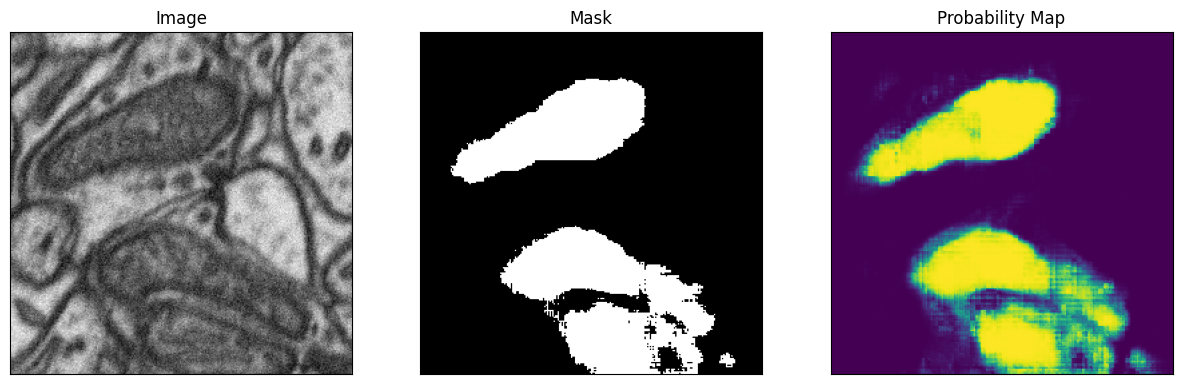

In [62]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

idx = random.randint(0, filtered_images.shape[0]-1)

test_image = dataset[idx]["image"]

ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Mask")

axes[2].imshow(medsam_seg_prob)
axes[2].set_title("Probability Map")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()


In [79]:
# Тестовые данные
large_test_images = tifffile.imread("/content/drive/MyDrive/testing.tif")
large_test_image = large_test_images[14]
patches = patchify(large_test_image, (256, 256), step=256)

In [80]:
array_size = 256

grid_size = 10

x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

xv, yv = np.meshgrid(x, y)

xv_list = xv.tolist()
yv_list = yv.tolist()

input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [76]:
print(np.array(input_points).shape)

(1, 1, 100, 2)


In [77]:
patches.shape

(3, 4, 256, 256)

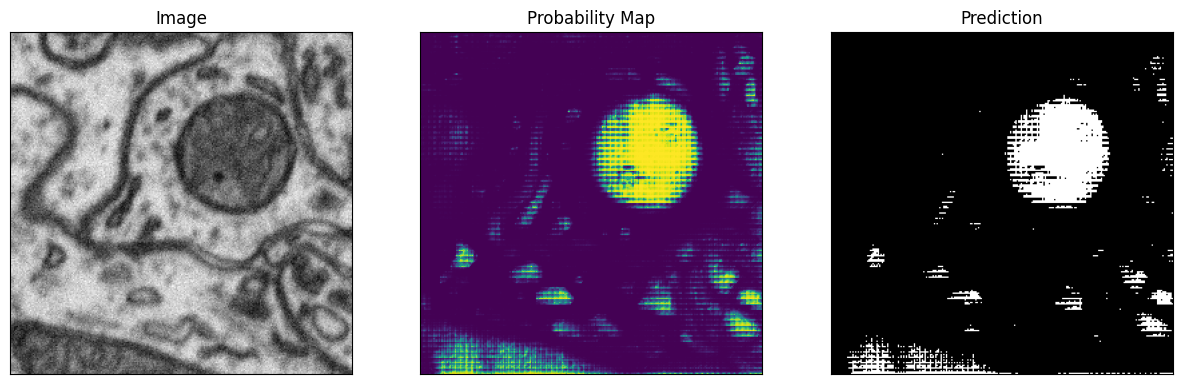

In [85]:
i, j = 2, 2

random_array = patches[i, j]

single_patch = Image.fromarray(random_array)

inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()

with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(np.array(single_patch), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(single_patch_prob)
axes[1].set_title("Probability Map")

axes[2].imshow(single_patch_prediction, cmap='gray')
axes[2].set_title("Prediction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()